tgb - 8/11/2019 - Goal is to start getting intuition on the ITCZ, based on ERA5  
1) Identify a case study based on MSE fields and contour length  
2) Calculate the scale-invariant potential and Landau function for that case  
3) See how much of the co-spectrum we are missing and infer "diffusivity"

# 1) Initialization

In [2]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

In [4]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/2016/'

In [5]:
MSE2016 = xr.open_mfdataset(path+'??MSE.nc')

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [12]:
MSE2016

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 8784)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Data variables:
    p61.162    (time, latitude, longitude) float32 dask.array<shape=(8784, 721, 1440), chunksize=(744, 721, 1440)>
    p62.162    (time, latitude, longitude) float32 dask.array<shape=(8784, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-25 15:59:47 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

In [19]:
MSE2016.time[1]

<xarray.DataArray 'time' ()>
array('2016-01-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-01-01T01:00:00
Attributes:
    long_name:  time

In [20]:
MSE2016.time[2]

<xarray.DataArray 'time' ()>
array('2016-01-01T02:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-01-01T02:00:00
Attributes:
    long_name:  time

In [25]:
dt = 3600
tcoor = dt*np.arange(0,MSE2016.time.shape[0])

In [26]:
tcoor[-1]/(24*3600)

365.9583333333333

# 2) General characteristics of the Atlantic ITCZ

tgb - 8/11/2019 - Define the Atlantic ITCZ as 300<longitude<360 and -20<latitude<20

In [137]:
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE2016['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE2016.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE2016.latitude.sel({'latitude':slice(latmax,latmin)})

In [130]:
MSEAtl

ERROR! Session/line number was not unique in database. History logging moved to new session 23


<xarray.DataArray 'p62.162' (time: 8784, latitude: 241, longitude: 240)>
dask.array<shape=(8784, 241, 240), dtype=float32, chunksize=(744, 241, 240)>
Coordinates:
  * longitude  (longitude) float32 300.0 300.25 300.5 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 30.0 29.75 29.5 29.25 ... -29.5 -29.75 -30.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Attributes:
    units:      J m**-2
    long_name:  Vertical integral of potential+internal+latent energy

tgb - 8/11/2019 - Choose a time-period based on the aggregation as measured by the MSE interquartile range

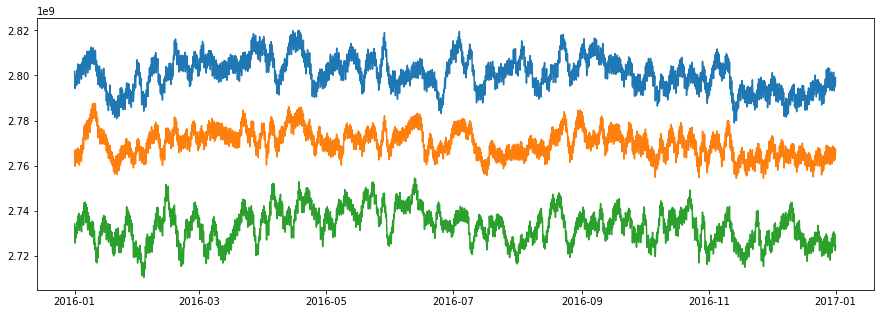

In [131]:
plt.figure(figsize=(15,5))

plt.plot(MSE2016.time,np.percentile(MSEAtl,75,axis=(1,2)))
plt.plot(MSE2016.time,np.percentile(MSEAtl,50,axis=(1,2)))
plt.plot(MSE2016.time,np.percentile(MSEAtl,25,axis=(1,2)))

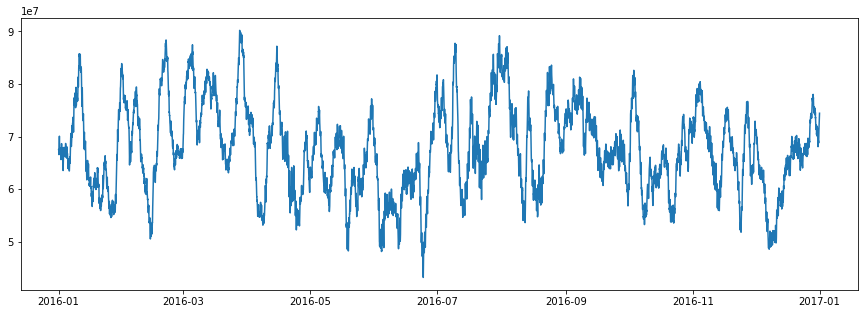

In [132]:
plt.figure(figsize=(15,5))

plt.plot(MSE2016.time,np.percentile(MSEAtl,75,axis=(1,2))-np.percentile(MSEAtl,25,axis=(1,2)))

tgb - 8/11/2019 - There may be some aggregation going on from June 1st to August 1st

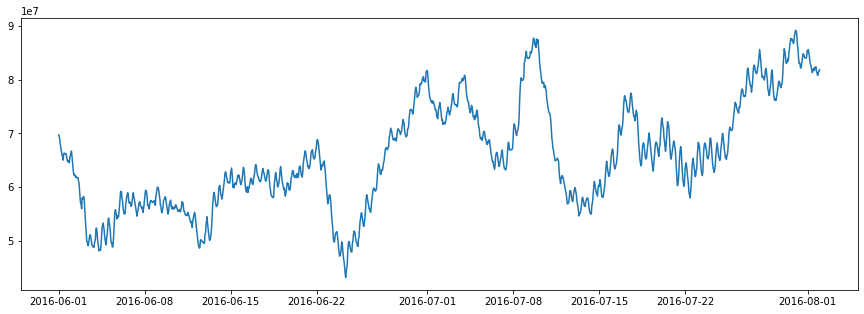

In [134]:
plt.figure(figsize=(15,5))
IQ = np.percentile(MSEAtl.sel({'time':slice('2016-06-01','2016-08-01')}),75,axis=(1,2))-\
np.percentile(MSEAtl.sel({'time':slice('2016-06-01','2016-08-01')}),25,axis=(1,2))
plt.plot(MSE2016.time.sel({'time':slice('2016-06-01','2016-08-01')}),IQ)

In [120]:
it = index_date(MSE2016.time.sel({'time':slice('2016-06-01','2016-08-01')}),date)

In [121]:
it

[0]

In [122]:
IQ = np.percentile(MSEAtl[it,:,:],75,axis=(1,2))-np.percentile(MSEAtl[it,:,:],25,axis=(1,2))

In [141]:
MED = np.percentile(MSEAtl.sel({'time':slice('2016-06-01','2016-08-01')}),50,axis=(1,2))

In [128]:
"%0.2e"%IQ

'6.68e+07'

In [162]:
lonAtl[contour[:,0].astype(int)]

<xarray.DataArray 'longitude' (longitude: 5)>
array([300.25, 300.25, 300.25, 300.25, 300.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 300.25 300.25 300.25 300.25 300.0
Attributes:
    units:      degrees_east
    long_name:  longitude

i= 0  & date= 2016-06-01T00:00:00
i= 1  & date= 2016-06-10T00:00:00
i= 2  & date= 2016-06-20T00:00:00
i= 3  & date= 2016-07-01T00:00:00
i= 4  & date= 2016-07-10T00:00:00
i= 5  & date= 2016-07-20T00:00:00
i= 6  & date= 2016-07-30T00:00:00
i= 7  & date= 2016-08-01T00:00:00


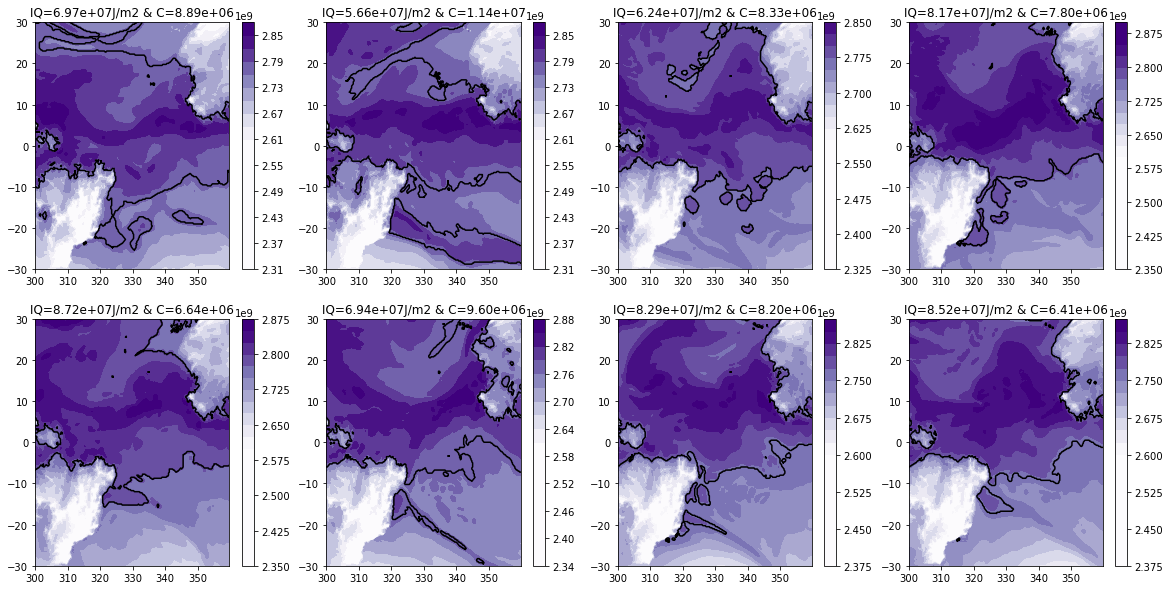

In [168]:
dx = 110/4
vmin = 2.6e9
vmax = 2.85e9

Tstr = ['2016-06-01T00:00:00','2016-06-10T00:00:00','2016-06-20T00:00:00','2016-07-01T00:00:00',\
       '2016-07-10T00:00:00','2016-07-20T00:00:00','2016-07-30T00:00:00','2016-08-01T00:00:00']

plt.figure(figsize=(20,10))

for i,date in enumerate(Tstr):
    print('i=',i,' & date=',date)
    plt.subplot(2,4,i+1)
    plt.contourf(lonAtl,latAtl,MSEAtl.sel({'time':date}),cmap='Purples',levels=20,vmin=vmin,vmax=vmax)
    
    it = index_date(MSE2016.time.sel({'time':slice('2016-06-01','2016-08-01')}),date)
    Contour = curve.get_contours(MSEAtl.sel({'time':date})>MED[it])
    
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    plt.colorbar()
    plt.title('IQ='+"%0.2e"%IQ[it]+'J/m2 & C='+"%0.2e"%L)

In [210]:
t_range = np.arange(0,np.size(MSE2016.time)-2)
dMSE_dt = (MSEAtl.values[t_range+2,:,:]-MSEAtl.values[t_range,:,:])/(2*dt)
dMSE_dt = np.concatenate((dMSE_dt[0:1,:,:],dMSE_dt,np.tile(dMSE_dt[-1,:,:],(1,1,1))),axis=0)

In [70]:
A = (MSEAtl[2,:,:]-MSEAtl[0,:,:])/(2*dt)

In [73]:
t_range = np.arange(0,np.size(MSE2016.time)-2)
dMSE_dt = (MSEAtl[t_range+2,:,:]-MSEAtl[t_range,:,:])/(2*dt)

In [82]:
dMSE_dt[2,:,:]

array([[-402.20444, -758.68445, -771.73334, ..., -389.15555, -392.3911 ,
        -480.71112],
       [-176.60445, -549.3689 , -719.4311 , ..., -412.05334, -464.35556,
        -562.4533 ],
       [ 104.64   , -271.39557, -510.11557, ..., -454.54224, -546.0978 ,
        -634.3822 ],
       ...,
       [-215.82222, -264.8889 , -281.24445, ..., -657.31555, -490.52444,
        -160.24889],
       [-222.36444, -284.48   , -271.43112, ..., -683.4489 , -621.2978 ,
        -300.83554],
       [-173.33333, -163.48445, -143.89333, ..., -729.24445, -689.9911 ,
        -438.18668]], dtype=float32)

In [55]:
# Find index of June 1st at Midnight
[i for i, x in enumerate(MSE2016.time.sel({'time':'2016-06-01T00:00:00'})==MSE2016.time) if x]

[3648]

In [56]:
def index_date(time_array,date_string):
    return [i for i, x in enumerate(time_array.sel({'time':date_string})==time_array) if x]

In [57]:
index_date(MSE2016.time,'2016-06-01T00:00:00')

[3648]

In [62]:
index_date(MSE2016.time,'2016-08-02T00:00:00')

[5136]

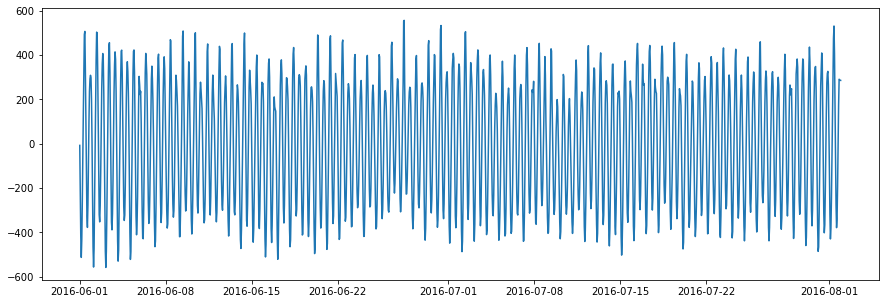

In [83]:
plt.figure(figsize=(15,5))

plt.plot(MSE2016.time.sel({'time':slice('2016-06-01','2016-08-01')}),\
         np.mean(dMSE_dt[3648:5136,:,:],axis=(1,2)))

tgb - 8/11/2019 - Check that time-derivative is consistent with temporal variations from June 1st to August 1st, 2016

In [105]:
MSEint = sin.trapz(x=tcoor[3648:5138],y=dMSE_dt[3648:5138,:,:],axis=0)

In [107]:
np.mean(MSEint,axis=(0,1))/1e9

-0.004867338575589377

In [109]:
np.mean(MSEAtl[5137,:,:].values-MSEAtl[3648,:,:].values,axis=(0,1))/1e9

-0.004827271

# 3) Calculate contour, potential, Landau

## 3.1) Contour

In [198]:
date1 = '2016-06-01T00:00:00'
date2 = '2016-08-01T00:00:00'

i1 = index_date(MSE2016.time,date1)[0]
i2 = index_date(MSE2016.time,date2)[0]

In [199]:
MED = np.percentile(MSEAtl[i1:i2,:,:],50,axis=(1,2))

In [200]:
IQ = np.percentile(MSEAtl[i1:i2,:,:],75,axis=(1,2))-np.percentile(MSEAtl[i1:i2,:,:],25,axis=(1,2))

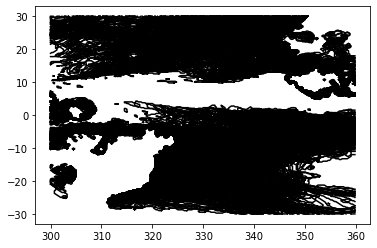

In [204]:
C = np.zeros((MED.shape[0],))

for i,it in enumerate(np.arange(i1,i2)):
    if (i%6)==0:
        print('i=',i,' & it=',it,'             ',end='\r')
        Contour = curve.get_contours(MSEAtl[it,:,:]>MED[i])
    
        L = 0
        for j,contour in enumerate(Contour):
            plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
            L += np.sum(contour*dx)
        
        C[i] = L

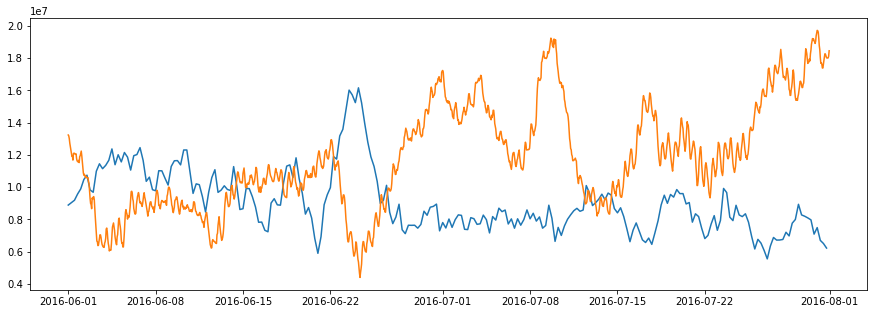

In [205]:
plt.figure(figsize=(15,5))
plt.plot(MSE2016.time.sel({'time':slice(date1,'2016-07-31T23:00:00')})[C>0],C[C>0])
plt.plot(MSE2016.time.sel({'time':slice(date1,'2016-07-31T23:00:00')}),IQ/3-1e7)

In [178]:
C.shape

(1464,)

In [180]:
C[1]

9088145.0

## 3.2) Potential

In [211]:
MSEAtl.shape

(8784, 241, 240)

In [212]:
dMSE_dt.shape

(8784, 241, 240)

In [213]:
F,binm,V = Landau.Landau_energy(MSEAtl[i1:i2,:,:],dMSE_dt[i1:i2,:,:],2.77e9,N_bins=30)

In [230]:
field_hist,bin_edges = np.histogram(MSEAtl[(i2-24*14):(i2),:,:].values.flatten(),bins=100)
bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

Text(0.5, 1.0, 'PDF FMSE')

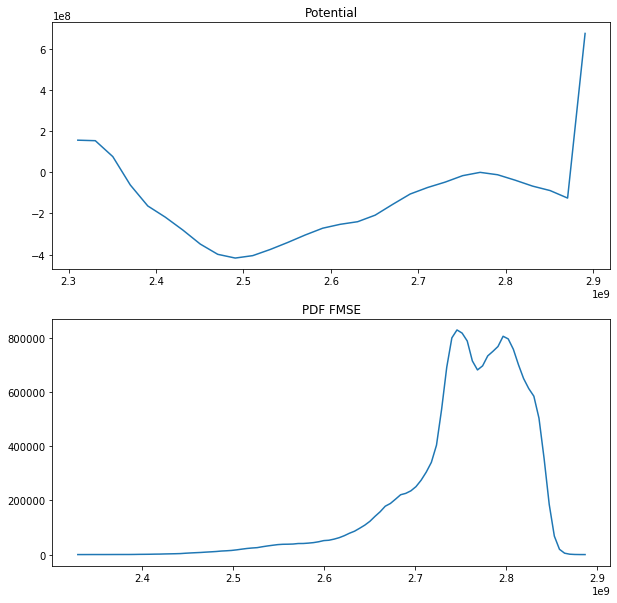

In [233]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(binm,V)
plt.title('Potential')
plt.subplot(2,1,2)
plt.plot(bin_mid,field_hist)
plt.title('PDF FMSE')

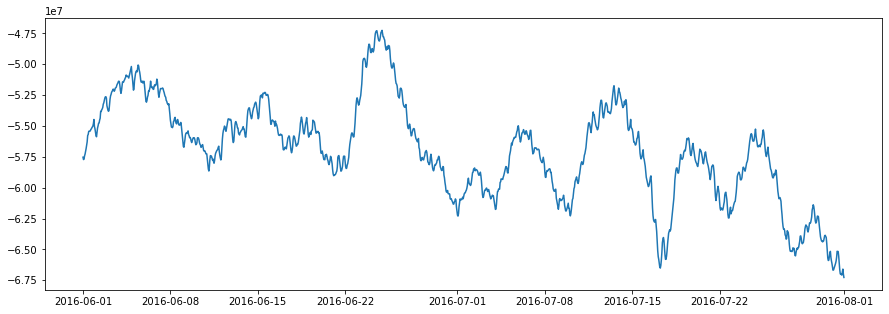

In [232]:
plt.figure(figsize=(15,5))
plt.plot(MSE2016.time.sel({'time':slice(date1,'2016-07-31T23:00:00')}),F)

## 3.3) Spectral rates and effective diffusion

In [277]:
erad = 6371e3; # Earth radius
deg = np.pi/180;

# Define (x,y) coordinates
Nx = np.size(lonAtl); Ny = np.size(latAtl)

dx = (2*np.pi*erad/Nx)*\
((np.max(lonAtl)-np.min(lonAtl))/360)*\
(np.sin(np.max(latAtl)*deg)-np.sin(np.min(latAtl)*deg))/\
((np.max(latAtl)-np.min(latAtl))*deg); # Mean x-increment
dx = dx.values
x = dx*np.arange(0,Nx)

dy = erad*(np.max(latAtl)-np.min(latAtl))*deg/Ny;
dy = dy.values
y = dy*np.arange(-Ny/2,Ny/2)

In [325]:
def cartesian_coord(lon_domain,lat_domain):
    
    # Returns: x,y,dx,dy
    
    erad = 6371e3; # Earth radius
    deg = np.pi/180; # degree to radian
    
    Nx = np.size(lon_domain)
    dx = (2*np.pi*erad/(Nx+1))*\
    ((np.max(lon_domain)-np.min(lon_domain))/360)*\
    (np.sin(np.max(lat_domain)*deg)-np.sin(np.min(lat_domain)*deg))/\
    ((np.max(lat_domain)-np.min(lat_domain))*deg); # Mean x-increment
    dx = dx.values
    
    Ny = np.size(lat_domain)
    dy = erad*(np.max(lat_domain)-np.min(lat_domain))*deg/(Ny+1);
    dy = dy.values
    y = dy*np.arange(0,Ny)
    
    return dx*np.arange(0,Nx),y+erad*np.min(lat_domain).values*deg,dx,dy

In [326]:
x,y,dx,dy = cartesian_coord(lonAtl,latAtl)

In [327]:
dx/1e3

26.32553596127247

In [328]:
dy/1e3

27.56899007716332

In [339]:
dMSE_dt[i1:i2:24,:,:].shape

(61, 241, 240)

In [340]:
import numpy.fft as fft
# Define wavenumbers
k,l,kmod,lam,kext,lext,kmodext = Landau.wavenumbers(x,y)
KM = kmod.flatten()
Nk = np.size(k); Nl = np.size(l);
dok = np.arange(1,Nk-1); dol = np.arange(1,Nl-1); # Index restriction for 2D FFT
    
# Fourier transform the fields
print('Calculating Fourier transforms...')
FFT_adv = fft.fft2(dMSE_dt[i1:i2:24,:,:])
FFT = fft.fft2(MSEAtl[i1:i2:24,:,:])

Calculating Fourier transforms...


In [352]:
GR = 2*np.real(np.conj(FFT_adv)*FFT)

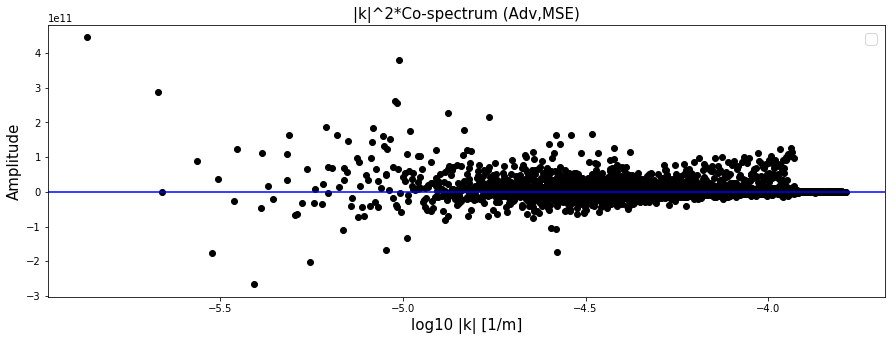

In [357]:
fz = 15

X = np.log10(KM)
Y = KM**2*np.mean(GR[:,dok,:][:,:,dol],axis=0).flatten()

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='b')
plt.scatter(X,24*3600*Y,color='k')
plt.title('|k|^2*Co-spectrum (Adv,MSE)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('Amplitude',fontsize=fz)
plt.legend(fontsize=fz)

tgb - 8/11/2019 - Now derive the MSE tendency from the potential and see the resulting spectral rates

In [359]:
binmid,V,tendm,tendstd = Landau.potential(MSEAtl[i1:i2,:,:],dMSE_dt[i1:i2,:,:],Nbins=30)

Text(0.5, 1.0, 'Tendency conditioned on MSE')

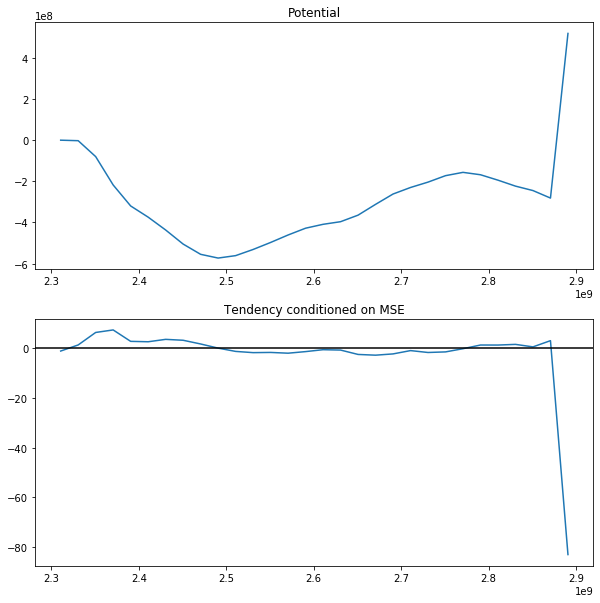

In [362]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(binmid,V)
plt.title('Potential')
plt.subplot(2,1,2)
plt.plot(binmid,tendm)
plt.axhline(y=0,color='k')
plt.title('Tendency conditioned on MSE')

In [465]:
tend_from_V = np.interp(MSEAtl[i1:i2,:,:],binmid,tendm[:,0])
#+\
#np.random.normal(loc=0,scale=np.interp(MSEAtl[i1:i2,:,:],binmid,tendstd[:,0]),size=MSEAtl[i1:i2,:,:].shape)

In [466]:
tend_from_V.shape

(1464, 241, 240)

In [467]:
bintest,Vtest,tendmtest,tendstdtest = Landau.potential(MSEAtl[i1:i2,:,:],tend_from_V,Nbins=30)

Text(0.5, 1.0, 'Tendency STD interpolated from potential')

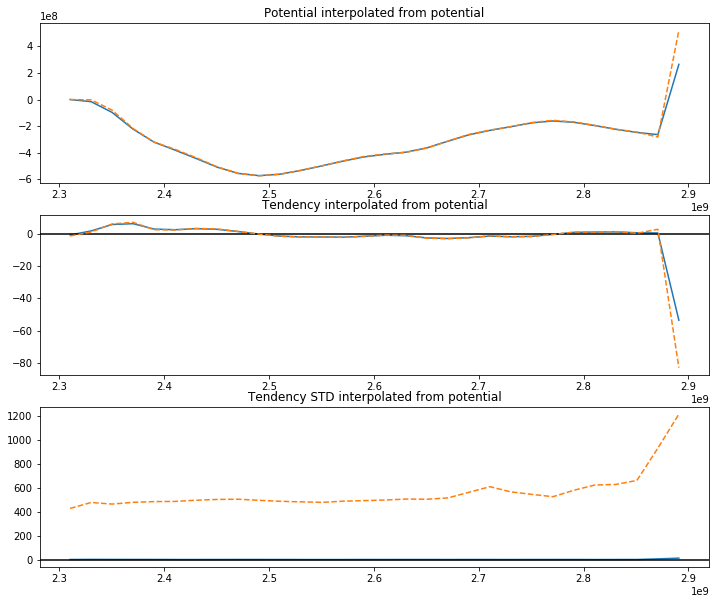

In [475]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(bintest,Vtest)
plt.plot(binmid,V,linestyle='--')
plt.title('Potential interpolated from potential')
plt.subplot(3,1,2)
plt.plot(bintest,tendmtest)
plt.axhline(y=0,color='k')
plt.plot(binmid,tendm,linestyle='--')
plt.title('Tendency interpolated from potential')
plt.subplot(3,1,3)
plt.plot(bintest,tendstdtest)
plt.axhline(y=0,color='k')
plt.plot(binmid,tendstd,linestyle='--')
plt.title('Tendency STD interpolated from potential')

In [476]:
tend_from_V.std()

1.389398082272823

In [477]:
dMSE_dt[i1:i2,:,:].std()

571.807

In [478]:
FFT_advtest = fft.fft2(tend_from_V[::24,:,:])

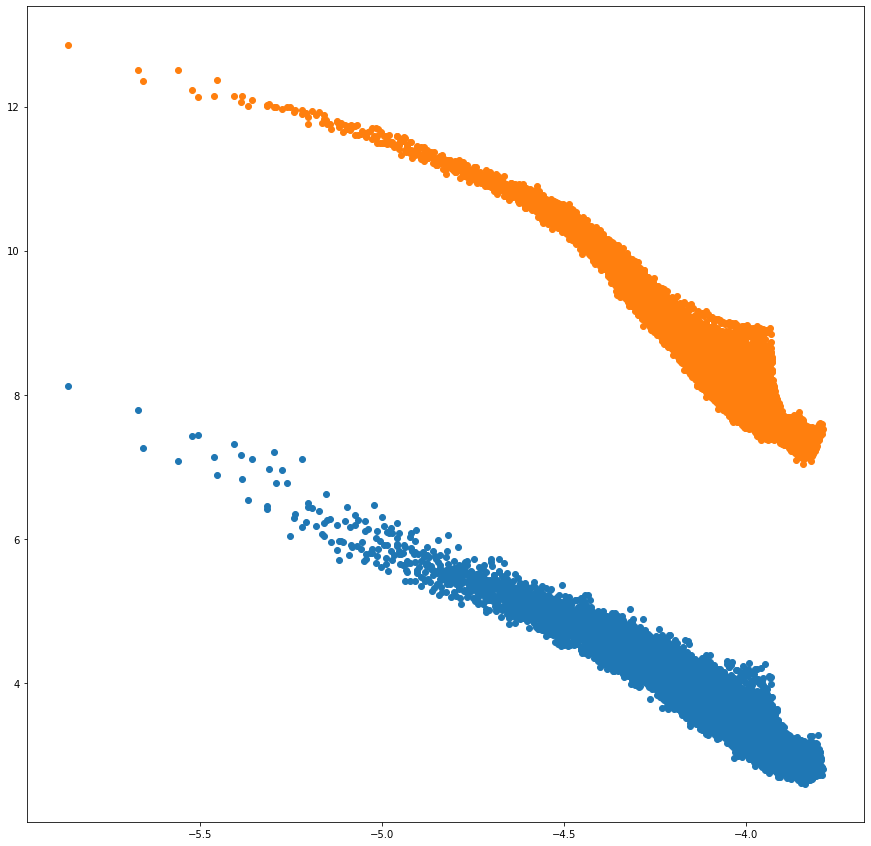

In [479]:
# Compare power spectra of FFT_advtest and FFT_adv
plt.figure(figsize=(15,15))

X = np.log10(KM)
Ytest = np.log10(np.mean(np.real(np.conj(FFT_advtest)*FFT_advtest)[:,dok,:][:,:,dol],axis=0).flatten())
Yadv = np.log10(np.mean(np.real(np.conj(FFT_adv)*FFT_adv)[:,dok,:][:,:,dol],axis=0).flatten())

plt.scatter(X,Ytest)
plt.scatter(X,Yadv)

In [488]:
coh_test = np.real(np.conj(FFT_advtest)*FFT)/(np.absolute(FFT_advtest)*np.absolute(FFT))
coh_adv = np.real(np.conj(FFT_adv)*FFT)/(np.absolute(FFT_adv)*np.absolute(FFT))

In [490]:
koct,coh_test_oct = Octave_var(kmod,coh_test[:,dok,:][:,:,dol])
koct,coh_adv_oct = Octave_var(kmod,coh_adv[:,dok,:][:,:,dol])

k octave is -20 and k index is 0
k octave is -19 and k index is 1
k octave is -18 and k index is 2
k octave is -17 and k index is 3
k octave is -16 and k index is 4
k octave is -15 and k index is 5
k octave is -14 and k index is 6
k octave is -13 and k index is 7
k octave is -20 and k index is 0
k octave is -19 and k index is 1
k octave is -18 and k index is 2
k octave is -17 and k index is 3
k octave is -16 and k index is 4
k octave is -15 and k index is 5
k octave is -14 and k index is 6
k octave is -13 and k index is 7


/home/tbeucler/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


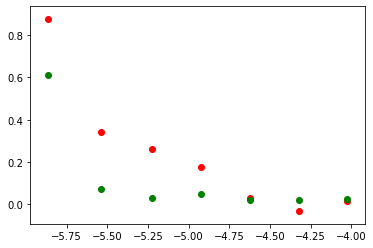

In [491]:
#X = np.log10(KM)
X = np.log10(koct)

#plt.scatter(X,np.mean(coh_test[:,dok,:][:,:,dol],axis=0).flatten(),color='r')
#plt.scatter(X,np.mean(coh_adv[:,dok,:][:,:,dol],axis=0).flatten(),color='g')
plt.scatter(X,np.mean(coh_test_oct,axis=0),color='r')
plt.scatter(X,np.mean(coh_adv_oct,axis=0),color='g')

In [443]:
GRtest = 2*np.real(np.conj(FFT_advtest)*FFT)

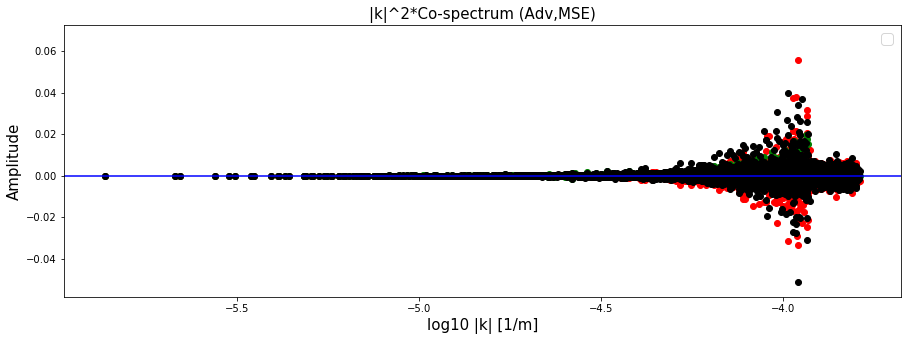

In [444]:
fz = 15

X = np.log10(KM)
Y = KM**4*np.mean(GRtest[:,dok,:][:,:,dol],axis=0).flatten()
Y0 = KM**4*np.mean(GR[:,dok,:][:,:,dol],axis=0).flatten()
Y1 = Y0-Y

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='b')
plt.scatter(X,Y,color='r')
plt.scatter(X,Y0,color='g')
plt.scatter(X,Y1,color='k')
plt.title('|k|^2*Co-spectrum (Adv,MSE)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('Amplitude',fontsize=fz)
plt.legend(fontsize=fz)

In [445]:
def Octave_var(kmod,var):

    ik = np.arange(0,np.size(kmod)); KM = kmod.flatten();
    koct_min = np.int(np.floor(np.log2(KM[ik[0]]))); 
    koct_max = np.int(np.ceil(np.log2(KM[ik[-1]]))); 
    koct = np.zeros((koct_max-koct_min,1));

    S = var.shape; 
    varoct = np.zeros((S[0],koct_max-koct_min));
    for i_koct in range(koct_min,koct_max):
        print('k octave is',i_koct,'and k index is',i_koct-koct_min)
        ind = (np.log2(KM)>=(i_koct-1) * (np.log2(KM)<i_koct));
        R = np.reshape(var,newshape=(S[0],S[1]*S[2]));
        if np.size(ind)>1: 
            varoct[:,i_koct-koct_min] = np.mean(R[:,ind],axis=1);
            koct[i_koct-koct_min] = np.mean(KM[ind]);
        else:
            varoct[:,i_koct-koct_min] = R[:,ind];
            koct[imin] = KM[ind];
            
    return koct,varoct

In [452]:
koct2,GRtest_oct = Octave_var(kmod,GRtest[:,dok,:][:,:,dol])

k octave is -20 and k index is 0
k octave is -19 and k index is 1
k octave is -18 and k index is 2
k octave is -17 and k index is 3
k octave is -16 and k index is 4
k octave is -15 and k index is 5
k octave is -14 and k index is 6
k octave is -13 and k index is 7


In [453]:
koct1,GR_oct = Octave_var(kmod,GR[:,dok,:][:,:,dol])

k octave is -20 and k index is 0
k octave is -19 and k index is 1
k octave is -18 and k index is 2
k octave is -17 and k index is 3
k octave is -16 and k index is 4
k octave is -15 and k index is 5
k octave is -14 and k index is 6
k octave is -13 and k index is 7


In [458]:
koct2.shape

(8, 1)

(-0.0001, 0.0003)

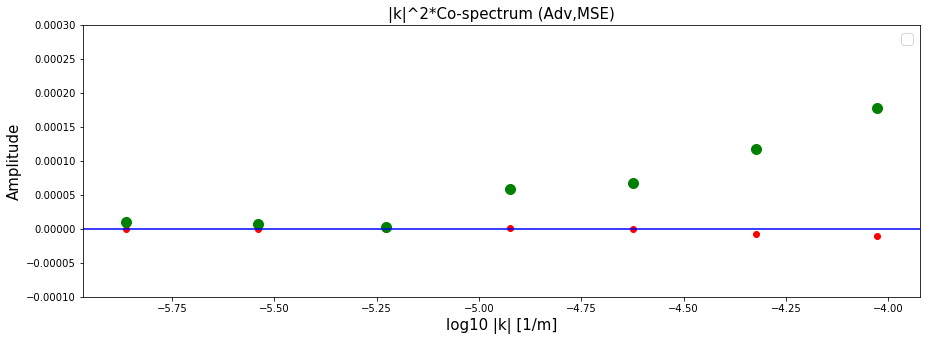

In [464]:
fz = 15

X = np.log10(koct2)
Y = koct2[:,0]**4*np.mean(GRtest_oct,axis=0).flatten()
X0 = np.log10(koct1)
Y0 = koct1[:,0]**4*np.mean(GR_oct,axis=0).flatten()
#Y1 = Y0-Y

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='b')
plt.scatter(X,Y,color='r')
plt.scatter(X0,Y0,color='g',s=100)
#plt.scatter(X,Y1,color='k')
plt.title('|k|^2*Co-spectrum (Adv,MSE)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('Amplitude',fontsize=fz)
plt.legend(fontsize=fz)
plt.ylim((-1e-4,3e-4))